In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, IBMQ, Aer, __qiskit_version__
from qiskit.circuit.library import QFT, GraphState, GroverOperator
from qiskit.qasm import pi

import numpy as np
import matplotlib.pyplot as plt
import os.path

from src.utils import *
from src.benchmarks import grover, qaoa, ghz, qft, qftentangled, shor, wstate, qpeinexact, qpeexact, graphstate, vqe, deutschjozsa, hhl, ae, qwalk
from src.benchmarks.qiskit_application_optimization import routing, tsp
from src.benchmarks.qiskit_application_finance import portfolioqaoa, portfoliovqe, pricingcall, pricingput
from src.benchmarks.qiskit_application_ml import qgan
from src.benchmarks.qiskit_application_nature import groundstate, excitedstate

from qiskit_nature.drivers import Molecule

In [2]:
ibm_native_gates = FakeMontreal().configuration().basis_gates
rigetti_native_gates = ['rx','rz','cz']

In [3]:
benchmarks = [graphstate, ghz, qft, wstate, qpeinexact, qpeexact, deutschjozsa,  shor, ae,  qftentangled] #hhl, grover, qaoa, vqe, qwalk
benchmarks_application = [portfolioqaoa, portfoliovqe,  qwalk, groundstate, excitedstate, routing,   tsp] #pricingcall,pricingput,qgan,
#benchmarks = [shor]
benchmarks_application = []

In [4]:
n_min = 3
n_max = 80
stepsize = 10

save_hist = False
save_png = False

ibm_smallest_fitting = True #smallest fitting architecture-> True, biggest architecture-> False
ancillary_mode ="noancilla"

In [5]:
def create_shor_benchmarks():
    small = [15,4] #18 qubits
    medium = [821, 4] #42 qubits
    large = [11777, 4] #58 qubits
    xlarge = [201209, 4] # 74 qubits
    benchmark_list = [small]#, medium, large, xlarge]
    for n, a in benchmark_list:        
        
        # Creating the circuit on Algorithmic Description Layer
        qc = shor.create_circuit(n,a)
        num_qubits = len(qc.qubits)
                   
        filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_algo, num_qubits, depth]) 

        # Creating the circuit on target-independent Description Layer        
        filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_indep, num_qubits, depth]) 
    
        for gate_set, gate_set_name in gate_sets:
            #try:          

            for opt_level in range(4):                    
                
                # Creating the circuit on target-dependent: native gates layer                
                filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                          opt_level, num_qubits, save_png, save_hist, 
                                                                          file_precheck=False)
                characteristics.append([filename_transpiled, n_actual, depth]) 
                
                # Creating the circuit on target-dependent: mapped layer
                filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                     ibm_smallest_fitting, save_png, save_hist, file_precheck=False)
                characteristics.append([filename_mapped, n_actual, depth])

In [6]:
def create_hhl_benchmarks(max_index:int):
    # n is not the number of qubits in this case
    for n in range(1,max_index):                
        # Creating the circuit on Algorithmic Description Layer
        qc = hhl.create_circuit(n)
        num_qubits = len(qc.qubits)
                   
        filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_algo, num_qubits, depth]) 

        # Creating the circuit on target-independent Description Layer        
        filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_indep, num_qubits, depth]) 
    
        for gate_set, gate_set_name in gate_sets:
            #try:          

            for opt_level in range(4):                    
                
                # Creating the circuit on target-dependent: native gates layer                
                filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                          opt_level, num_qubits, save_png, save_hist, 
                                                                          file_precheck=False)
                characteristics.append([filename_transpiled, n_actual, depth]) 
                
                # Creating the circuit on target-dependent: mapped layer
                filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                     ibm_smallest_fitting, save_png, save_hist, file_precheck=False)
                characteristics.append([filename_mapped, n_actual, depth])

In [7]:
def create_routing_benchmarks(max_index:int):
    # n is not the number of qubits in this case
    for n in range(2,max_index):                
        # Creating the circuit on Algorithmic Description Layer
        qc = routing.create_circuit(n,2)
        num_qubits = (len(qc.qubits))
                   
        filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_algo, num_qubits, depth]) 

        # Creating the circuit on target-independent Description Layer        
        filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_indep, num_qubits, depth]) 
    
        for gate_set, gate_set_name in gate_sets:
            #try:          

            for opt_level in range(4):                    
                
                # Creating the circuit on target-dependent: native gates layer                
                filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                          opt_level, num_qubits, save_png, save_hist, 
                                                                          file_precheck=False)
                characteristics.append([filename_transpiled, n_actual, depth]) 
                
                # Creating the circuit on target-dependent: mapped layer
                filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                     ibm_smallest_fitting, save_png, save_hist, file_precheck=False)
                characteristics.append([filename_mapped, n_actual, depth])

In [8]:
def create_tsp_benchmarks(max_index:int):
    # n is not the number of qubits in this case
    for n in range(3,max_index):                
        # Creating the circuit on Algorithmic Description Layer
        qc = tsp.create_circuit(n)
        num_qubits = (len(qc.qubits))
                   
        filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_algo, num_qubits, depth]) 

        # Creating the circuit on target-independent Description Layer        
        filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_indep, num_qubits, depth]) 
    
        for gate_set, gate_set_name in gate_sets:
            #try:          

            for opt_level in range(4):                    
                
                # Creating the circuit on target-dependent: native gates layer                
                filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                          opt_level, num_qubits, save_png, save_hist, 
                                                                          file_precheck=False)
                characteristics.append([filename_transpiled, n_actual, depth]) 
                
                # Creating the circuit on target-dependent: mapped layer
                filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                     ibm_smallest_fitting, save_png, save_hist, file_precheck=False)
                characteristics.append([filename_mapped, n_actual, depth])

In [9]:
def create_groundstate_benchmarks():
    
    molecule = Molecule(
        geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
    )

    qc = groundstate.create_circuit(molecule)
    num_qubits = (len(qc.qubits))

    filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
    characteristics.append([filename_algo, num_qubits, depth]) 

    # Creating the circuit on target-independent Description Layer        
    filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist)
    characteristics.append([filename_indep, num_qubits, depth]) 

    for gate_set, gate_set_name in gate_sets:
        #try:          

        for opt_level in range(4):                    

            # Creating the circuit on target-dependent: native gates layer                
            filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                      opt_level, num_qubits, save_png, save_hist, 
                                                                      file_precheck=False)
            characteristics.append([filename_transpiled, n_actual, depth]) 

            # Creating the circuit on target-dependent: mapped layer
            filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                 ibm_smallest_fitting, save_png, save_hist, file_precheck=False)
            characteristics.append([filename_mapped, n_actual, depth])

In [10]:
def create_excitedstate_benchmarks():
    
    molecule = Molecule(
        geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
    )
    qc = excitedstate.create_circuit(molecule)
    num_qubits = (len(qc.qubits))

    filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
    characteristics.append([filename_algo, num_qubits, depth]) 

    # Creating the circuit on target-independent Description Layer        
    filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist)
    characteristics.append([filename_indep, num_qubits, depth]) 

    for gate_set, gate_set_name in gate_sets:
        #try:          

        for opt_level in range(4):                    

            # Creating the circuit on target-dependent: native gates layer                
            filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                      opt_level, num_qubits, save_png, save_hist, 
                                                                      file_precheck=False)
            characteristics.append([filename_transpiled, n_actual, depth]) 

            # Creating the circuit on target-dependent: mapped layer
            filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                 ibm_smallest_fitting, save_png, save_hist, file_precheck=False)
            characteristics.append([filename_mapped, n_actual, depth])

In [11]:
def create_pricingcall_benchmarks(max_index:int):
    # n is not the number of qubits in this case
    for n in range(3,max_index):                
        # Creating the circuit on Algorithmic Description Layer
        qc = pricingcall.create_circuit(n)
        num_qubits = str(len(qc.qubits))
                   
        filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_algo, num_qubits, depth]) 

        # Creating the circuit on target-independent Description Layer        
        filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_indep, num_qubits, depth]) 
    
        for gate_set, gate_set_name in gate_sets:
            #try:          

            for opt_level in range(4):                    
                
                # Creating the circuit on target-dependent: native gates layer                
                filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                          opt_level, num_qubits, save_png, save_hist, 
                                                                          file_precheck=False)
                characteristics.append([filename_transpiled, n_actual, depth]) 
                
                # Creating the circuit on target-dependent: mapped layer
                filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                     ibm_smallest_fitting, save_png, save_hist, file_precheck=False)
                characteristics.append([filename_mapped, n_actual, depth])

In [12]:
def create_pricingput_benchmarks(max_index:int):
    # n is not the number of qubits in this case
    for n in range(3,max_index):                
        # Creating the circuit on Algorithmic Description Layer
        qc = pricingput.create_circuit(n)
        num_qubits = str(len(qc.qubits))
                   
        filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_algo, num_qubits, depth]) 

        # Creating the circuit on target-independent Description Layer        
        filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist)
        characteristics.append([filename_indep, num_qubits, depth]) 
    
        for gate_set, gate_set_name in gate_sets:
            #try:          

            for opt_level in range(4):                    
                
                # Creating the circuit on target-dependent: native gates layer                
                filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                          opt_level, num_qubits, save_png, save_hist, 
                                                                          file_precheck=False)
                characteristics.append([filename_transpiled, n_actual, depth]) 
                
                # Creating the circuit on target-dependent: mapped layer
                filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                     ibm_smallest_fitting, save_png, save_hist, file_precheck=False)
                characteristics.append([filename_mapped, n_actual, depth])

In [13]:
characteristics = []
gate_sets = [(ibm_native_gates, "ibm"), (rigetti_native_gates, "rigetti")]

for benchmark in benchmarks+benchmarks_application:
    file_precheck = True
    print(benchmark)    
    
    # First treat all "special" benchmarks with n != num qubits or different constructor parameters    
    if benchmark == shor: 
        #create_shor_benchmarks()
        continue
    elif benchmark == hhl: 
        create_hhl_benchmarks(2) # 5 is max number which fits my RAM
        continue
    elif benchmark == pricingcall: 
        create_pricingcall_benchmarks(5) # max val is not tested yet, but indep layer generation fails
        continue
    elif benchmark == pricingput:
        create_pricingput_benchmarks(5) # max val is not tested yet, but indep layer generation fails
        continue
    elif benchmark == groundstate: 
        create_groundstate_benchmarks()
        continue
    elif benchmark == excitedstate: 
        create_excitedstate_benchmarks()
        continue
    elif benchmark == tsp: 
        create_tsp_benchmarks(4) # 5 is max number which fits my RAM
        continue
    elif benchmark == routing: 
        create_routing_benchmarks(4) # for a higher parameters it takes forever on my laptop
        continue
    
    for n in range(n_min, n_max, stepsize):  
        try:
            # Creating the circuit on Algorithmic Description Layer
            if (benchmark == grover or benchmark == qwalk):
                qc = benchmark.create_circuit(n, ancillary_mode=ancillary_mode)
                qc.name = qc.name + "-" + ancillary_mode
                file_precheck = False
            else:
                qc = benchmark.create_circuit(n)

            filename_algo, depth = handle_algorithm_layer(qc, n, save_png, save_hist)
            characteristics.append([filename_algo, n, depth]) 

            # Creating the circuit on target-independent Description Layer        
            filename_indep, depth = get_indep_layer(qc, n, save_png, save_hist)
            characteristics.append([filename_indep, n, depth]) 

            for gate_set, gate_set_name in gate_sets:
                try:          

                    for opt_level in range(4):                    

                        # Creating the circuit on target-dependent: native gates layer                
                        filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                                  opt_level, n, save_png, save_hist, 
                                                                                  file_precheck=file_precheck)
                        characteristics.append([filename_transpiled, n_actual, depth]) 

                        # Creating the circuit on target-dependent: mapped layer
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             ibm_smallest_fitting, save_png, save_hist, file_precheck=file_precheck)
                        characteristics.append([filename_mapped, n_actual, depth])

                except:
                    print("\n Problem occured: ", benchmark, n, gate_set_name)
        except:
            print("\n Problem occured: ", benchmark, n, gate_set_name)
            continue

            

<module 'src.benchmarks.graphstate' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/graphstate.py'>
qpy_output/graphstate_algorithm_3.qpy already existed
qpy_output/graphstate_t-indep_3.qpy already existed
qasm_output/graphstate_transpiled_ibm_opt0_3.qasm already existed
qasm_output/graphstate_mapped_ibm-s_opt0_3.qasm already existed
qasm_output/graphstate_transpiled_ibm_opt1_3.qasm already existed
qasm_output/graphstate_mapped_ibm-s_opt1_3.qasm already existed
qasm_output/graphstate_transpiled_ibm_opt2_3.qasm already existed
qasm_output/graphstate_mapped_ibm-s_opt2_3.qasm already existed
qasm_output/graphstate_transpiled_ibm_opt3_3.qasm already existed
qasm_output/graphstate_mapped_ibm-s_opt3_3.qasm already existed
qasm_output/graphstate_transpiled_rigetti_opt0_3.qasm already existed
qasm_output/graphstate_mapped_rigetti_opt0_3.qasm already existed
qasm_output/graphstate_transpiled_rigetti_opt1_3.qasm already existed
qasm_output/graphstate_mapped_rigetti_opt1_3.qasm already

qasm_output/ghz_mapped_rigetti_opt2_3.qasm already existed
qasm_output/ghz_transpiled_rigetti_opt3_3.qasm already existed
qasm_output/ghz_mapped_rigetti_opt3_3.qasm already existed
qpy_output/ghz_algorithm_13.qpy already existed
qpy_output/ghz_t-indep_13.qpy already existed
qasm_output/ghz_transpiled_ibm_opt0_13.qasm already existed
qasm_output/ghz_mapped_ibm-s_opt0_13.qasm already existed
qasm_output/ghz_transpiled_ibm_opt1_13.qasm already existed
qasm_output/ghz_mapped_ibm-s_opt1_13.qasm already existed
qasm_output/ghz_transpiled_ibm_opt2_13.qasm already existed
qasm_output/ghz_mapped_ibm-s_opt2_13.qasm already existed
qasm_output/ghz_transpiled_ibm_opt3_13.qasm already existed
qasm_output/ghz_mapped_ibm-s_opt3_13.qasm already existed
qasm_output/ghz_transpiled_rigetti_opt0_13.qasm already existed
qasm_output/ghz_mapped_rigetti_opt0_13.qasm already existed
qasm_output/ghz_transpiled_rigetti_opt1_13.qasm already existed
qasm_output/ghz_mapped_rigetti_opt1_13.qasm already existed
qasm_

qasm_output/qft_transpiled_ibm_opt2_23.qasm already existed
qasm_output/qft_mapped_ibm-s_opt2_23.qasm already existed
qasm_output/qft_transpiled_ibm_opt3_23.qasm already existed
qasm_output/qft_mapped_ibm-s_opt3_23.qasm already existed
qasm_output/qft_transpiled_rigetti_opt0_23.qasm already existed
qasm_output/qft_mapped_rigetti_opt0_23.qasm already existed
qasm_output/qft_transpiled_rigetti_opt1_23.qasm already existed
qasm_output/qft_mapped_rigetti_opt1_23.qasm already existed
qasm_output/qft_transpiled_rigetti_opt2_23.qasm already existed
qasm_output/qft_mapped_rigetti_opt2_23.qasm already existed
qasm_output/qft_transpiled_rigetti_opt3_23.qasm already existed
qasm_output/qft_mapped_rigetti_opt3_23.qasm already existed
qpy_output/qft_algorithm_33.qpy already existed
qpy_output/qft_t-indep_33.qpy already existed
qasm_output/qft_transpiled_ibm_opt0_33.qasm already existed
qasm_output/qft_mapped_ibm-s_opt0_33.qasm already existed
qasm_output/qft_transpiled_ibm_opt1_33.qasm already exis

qasm_output/wstate_transpiled_rigetti_opt1_33.qasm already existed
qasm_output/wstate_transpiled_rigetti_opt2_33.qasm already existed
qasm_output/wstate_transpiled_rigetti_opt3_33.qasm already existed
qpy_output/wstate_algorithm_43.qpy already existed
qpy_output/wstate_t-indep_43.qpy already existed
qasm_output/wstate_transpiled_ibm_opt0_43.qasm already existed
qasm_output/wstate_mapped_ibm-s_opt0_43.qasm already existed
qasm_output/wstate_transpiled_ibm_opt1_43.qasm already existed
qasm_output/wstate_mapped_ibm-s_opt1_43.qasm already existed
qasm_output/wstate_transpiled_ibm_opt2_43.qasm already existed
qasm_output/wstate_mapped_ibm-s_opt2_43.qasm already existed
qasm_output/wstate_transpiled_ibm_opt3_43.qasm already existed
qasm_output/wstate_mapped_ibm-s_opt3_43.qasm already existed
qasm_output/wstate_transpiled_rigetti_opt0_43.qasm already existed
qasm_output/wstate_transpiled_rigetti_opt1_43.qasm already existed
qasm_output/wstate_transpiled_rigetti_opt2_43.qasm already existed
qa

qasm_output/qpeinexact_transpiled_rigetti_opt2_43.qasm already existed
qasm_output/qpeinexact_transpiled_rigetti_opt3_43.qasm already existed
qpy_output/qpeinexact_algorithm_53.qpy already existed
qpy_output/qpeinexact_t-indep_53.qpy already existed
qasm_output/qpeinexact_transpiled_ibm_opt0_53.qasm already existed
qasm_output/qpeinexact_mapped_ibm-s_opt0_53.qasm already existed
qasm_output/qpeinexact_transpiled_ibm_opt1_53.qasm already existed
qasm_output/qpeinexact_mapped_ibm-s_opt1_53.qasm already existed
qasm_output/qpeinexact_transpiled_ibm_opt2_53.qasm already existed
qasm_output/qpeinexact_mapped_ibm-s_opt2_53.qasm already existed
qasm_output/qpeinexact_transpiled_ibm_opt3_53.qasm already existed
qasm_output/qpeinexact_mapped_ibm-s_opt3_53.qasm already existed
qasm_output/qpeinexact_transpiled_rigetti_opt0_53.qasm already existed
qasm_output/qpeinexact_transpiled_rigetti_opt1_53.qasm already existed
qasm_output/qpeinexact_transpiled_rigetti_opt2_53.qasm already existed
qasm_outp

qasm_output/qpeexact_transpiled_rigetti_opt2_53.qasm already existed
qasm_output/qpeexact_transpiled_rigetti_opt3_53.qasm already existed
qpy_output/qpeexact_algorithm_63.qpy already existed
qpy_output/qpeexact_t-indep_63.qpy already existed
qasm_output/qpeexact_transpiled_ibm_opt0_63.qasm already existed
qasm_output/qpeexact_mapped_ibm-s_opt0_63.qasm already existed
qasm_output/qpeexact_transpiled_ibm_opt1_63.qasm already existed
qasm_output/qpeexact_mapped_ibm-s_opt1_63.qasm already existed
qasm_output/qpeexact_transpiled_ibm_opt2_63.qasm already existed
qasm_output/qpeexact_mapped_ibm-s_opt2_63.qasm already existed
qasm_output/qpeexact_transpiled_ibm_opt3_63.qasm already existed
qasm_output/qpeexact_mapped_ibm-s_opt3_63.qasm already existed
qasm_output/qpeexact_transpiled_rigetti_opt0_63.qasm already existed
qasm_output/qpeexact_transpiled_rigetti_opt1_63.qasm already existed
qasm_output/qpeexact_transpiled_rigetti_opt2_63.qasm already existed
qasm_output/qpeexact_transpiled_rigetti

qpy_output/ae_algorithm_43.qpy already existed

 Problem occured:  <module 'src.benchmarks.ae' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/ae.py'> 43 rigetti
qpy_output/ae_algorithm_53.qpy already existed

 Problem occured:  <module 'src.benchmarks.ae' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/ae.py'> 53 rigetti
qpy_output/ae_algorithm_63.qpy already existed

 Problem occured:  <module 'src.benchmarks.ae' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/ae.py'> 63 rigetti

 Problem occured:  <module 'src.benchmarks.ae' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/ae.py'> 73 ibm
<module 'src.benchmarks.qftentangled' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/qftentangled.py'>
qpy_output/qftentangled_algorithm_3.qpy already existed
qpy_output/qftentangled_t-indep_3.qpy already existed
qasm_output/qftentangled_transpiled_ibm_opt0_3.qasm already existed
qasm_output/qftentangled_mapped_ibm-s_opt0_3.qasm already existed



 Problem occured:  <module 'src.benchmarks.qftentangled' from '/Users/nils/Documents/repos/DAQCBench/src/benchmarks/qftentangled.py'> 73 ibm


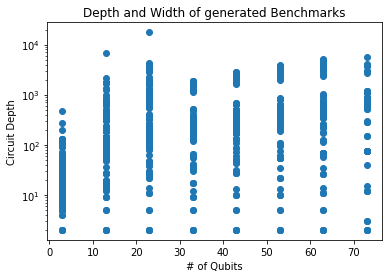

In [23]:
characteristics = np.array(characteristics)
plt.scatter(x=characteristics[:,1].astype(int), y=characteristics[:,2].astype(int))
plt.yscale('log')
plt.title('Depth and Width of generated Benchmarks')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth');
plt.savefig("test")

In [15]:
len(characteristics)

1096

In [107]:
width_depth_0=[]
width_depth_1=[]
width_depth_2=[]
width_depth_3=[]

for f in characteristics:
    if "algorithm" in f[0]:
        width_depth_0.append([f[1], f[2]])       

    elif "t-indep" in f[0]:
        width_depth_1.append([f[1], f[2]])  

    elif "transpiled" in f[0]:
        width_depth_2.append([f[1], f[2]])  
        
    elif "mapped" in f[0]:
        width_depth_3.append([f[1], f[2]])   


/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_2892/2709470504.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 10200])


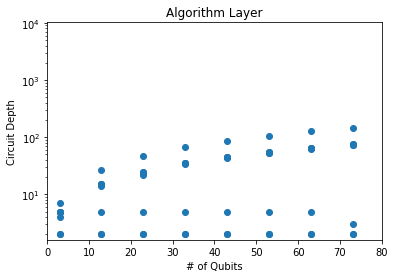

/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_2892/2709470504.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 10200])


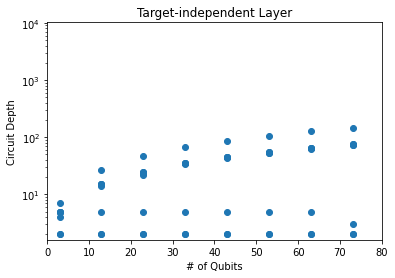

/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_2892/2709470504.py:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 10200])


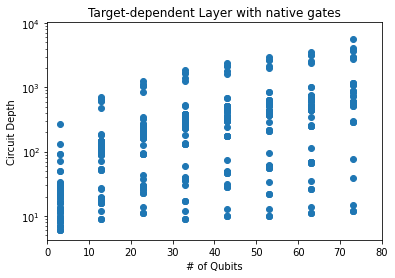

/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_2892/2709470504.py:45: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 10200])


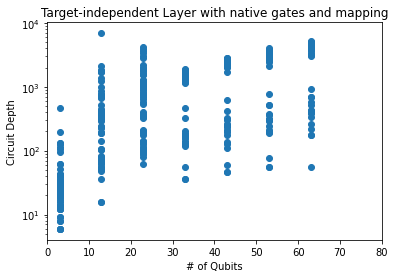

In [185]:
import random
import numpy
from matplotlib import pyplot



width_depth_0 = np.array(width_depth_0)
width_depth_1 = np.array(width_depth_1)
width_depth_2 = np.array(width_depth_2)
width_depth_3 = np.array(width_depth_3)

plt.scatter(x=width_depth_0[:,0].astype(int), y=width_depth_0[:,1].astype(int), label="0")
plt.yscale('log')
plt.title('Algorithm Layer')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth')
plt.xlim([0, 80])
plt.ylim([0, 10200])
plt.savefig("layer_0.png")
pyplot.show();
plt.scatter(x=width_depth_1[:,0].astype(int), y=width_depth_1[:,1].astype(int), label="1")
plt.yscale('log')
plt.title('Target-independent Layer')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth')
plt.xlim([0, 80])
plt.ylim([0, 10200])
plt.savefig("layer_1.png")
pyplot.show();
plt.scatter(x=width_depth_2[:,0].astype(int), y=width_depth_2[:,1].astype(int), label="2")
plt.yscale('log')
plt.title('Target-dependent Layer with native gates')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth')
plt.xlim([0, 80])
plt.ylim([0, 10200])
plt.savefig("layer_2.png")
pyplot.show();
plt.scatter(x=width_depth_3[:,0].astype(int), y=width_depth_3[:,1].astype(int), label="3")
plt.yscale('log')
plt.title('Target-independent Layer with native gates and mapping')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth')
plt.xlim([0, 80])
plt.ylim([0, 10200])
plt.savefig("layer_3.png")
pyplot.show();


Grover Test

In [16]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import GroverOperator
from qiskit.qasm import pi
from qiskit.algorithms import Grover

# checked

def create_circuit(n: int, ancillary_mode: str = 'noancilla'):
    n = n - 1  # magic number due to the flag qubit
    q = QuantumRegister(n, 'q')
    flag = AncillaRegister(1, 'flag')

    state_preparation = QuantumCircuit(q, flag)
    state_preparation.h(q)
    state_preparation.x(flag)

    oracle = QuantumCircuit(q, flag)
    oracle.mct(q, flag)

    operator = GroverOperator(oracle, mcx_mode=ancillary_mode)
    iterations = Grover.optimal_num_iterations(1, n)

    num_qubits = operator.num_qubits - 1 #-1 because last qubit is "flag" qubit and already taken care of

    # num_qubits may differe now depending on the mcx_mode

    q2 = QuantumRegister(num_qubits, 'q')
    qc = QuantumCircuit(q2, flag, name='grover')
    qc.compose(state_preparation, inplace=True)

    qc.compose(operator.power(iterations), inplace=True)
    qc.measure_all()

    return qc




In [17]:
qc = create_circuit(9)
qc.draw()


┌───┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐┌────┐»
   q_0: ┤ H ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├┤0   ├»
        ├───┤│    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
   q_1: ┤ H ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├┤1   ├»
        ├───┤│    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
   q_2: ┤ H ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├┤2   ├»
        ├───┤│    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
   q_3: ┤ H ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├┤3   ├»
        ├───┤│    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
   q_4: ┤ H ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├»
        ├───┤│    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
   q_5: ┤ H ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├┤5   ├»
        ├───┤│    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
   q_6: ┤ H ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├┤6   ├»
        ├───┤│    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
   q_7: ┤ H ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├┤7   ├»
        ├───┤│    ││    ││    ││    ││    ││    ││    ││    ││    ││    ││    │»
  flag: ┤ X ├┤8   ├┤8   ├┤8   ├┤8   ├┤8   ├┤8   ├┤8   ├┤8   ├┤8   ├┤8   ├┤8   ├»
        └───┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘└────┘»
meas: 9/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌────┐ ░ ┌─┐                        
«   q_0: ┤0   ├─░─┤M├────────────────────────
«        │    │ ░ └╥┘┌─┐                     
«   q_1: ┤1   ├─░──╫─┤M├─────────────────────
«        │    │ ░  ║ └╥┘┌─┐                  
«   q_2: ┤2   ├─░──╫──╫─┤M├──────────────────
«        │    │ ░  ║  ║ └╥┘┌─┐               
«   q_3: ┤3   ├─░──╫──╫──╫─┤M├───────────────
«        │    │ ░  ║  ║  ║ └╥┘┌─┐            
«   q_4: ┤4 Q ├─░──╫──╫──╫──╫─┤M├────────────
«        │    │ ░  ║  ║  ║  ║ └╥┘┌─┐         
«   q_5: ┤5   ├─░──╫──╫──╫──╫──╫─┤M├─────────
«        │    │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐      
«   q_6: ┤6   ├─░──╫──╫──╫──╫──╫──╫─┤M├──────
«        │    │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
«   q_7: ┤7   ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├───
«        │    │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
«  flag: ┤8   ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
«        └────┘ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
«meas: 9/══════════╩══╩══╩══╩══╩══╩══╩══╩══╩═
«                  0  1  2  3  4  5  6  7  8

In [18]:
import numpy as np
from qiskit.algorithms.linear_solvers.matrices.tridiagonal_toeplitz import TridiagonalToeplitz
from qiskit.algorithms.linear_solvers.hhl import HHL

def create_circuit(n: int):
    a = 1
    b = -1 / 3

    vector = np.array([1] + [0] * (2 ** n - 1))
    tridi_matrix = TridiagonalToeplitz(n, a, b)
    qc = HHL().solve(tridi_matrix, vector).state

    qc.name = "HHL"
    qc.measure_all()

    return qc

In [19]:
qc = create_circuit(1).decompose().decompose().decompose()
qc.draw()

┌───────────────────┐           ┌────────────────────┐»
  q44349: ┤ U(-π/40,3π/2,π/2) ├───────────┤ U(π/20,3π/2,π/2,0) ├»
          └────┬─────────┬────┘┌─────────┐└─────────┬──────────┘»
q44350_0: ─────┤ U2(0,π) ├─────┤ P(3π/8) ├──────────■───────────»
               ├─────────┤     ├─────────┤                      »
q44350_1: ─────┤ U2(0,π) ├─────┤ P(3π/4) ├──────────────────────»
               ├─────────┤     ├─────────┤                      »
q44350_2: ─────┤ U2(0,π) ├─────┤ P(3π/2) ├──────────────────────»
               └─────────┘     └─────────┘                      »
  q44351: ──────────────────────────────────────────────────────»
                                                                »
  meas: 5/══════════════════════════════════════════════════════»
                                                                »
«          ┌────────────────────┐┌────────────────────┐┌────────────────────┐»
«  q44349: ┤ U(π/20,3π/2,π/2,0) ├┤ U(π/20,3π/2,π/2,0) ├┤ U(π/20,3π/2,π/2,0) ├»
«          └─────────┬──────────┘└─────────┬──────────┘└─────────┬──────────┘»
«q44350_0: ──────────■─────────────────────■─────────────────────■───────────»
«                                                                            »
«q44350_1: ──────────────────────────────────────────────────────────────────»
«                                                                            »
«q44350_2: ──────────────────────────────────────────────────────────────────»
«                                                                            »
«  q44351: ──────────────────────────────────────────────────────────────────»
«                                                                            »
«  meas: 5/══════════════════════════════════════════════════════════════════»
«                                                                            »
«          ┌────────────────────┐┌──────────────────┐┌───────────────────┐»
«  q44349: ┤ U(π/20,3π/2,π/2,0) ├┤ U(π/40,3π/2,π/2) ├┤ U(-π/32,3π/2,π/2) ├»
«          └─────────┬──────────┘└──────────────────┘└───────────────────┘»
«q44350_0: ──────────■────────────────────────────────────────────────────»
«                                                                         »
«q44350_1: ───────────────────────────────────────────────────────────────»
«                                                                         »
«q44350_2: ───────────────────────────────────────────────────────────────»
«                                                                         »
«  q44351: ───────────────────────────────────────────────────────────────»
«                                                                         »
«  meas: 5/═══════════════════════════════════════════════════════════════»
«                                                                         »
«          ┌────────────────────┐┌────────────────────┐┌────────────────────┐»
«  q44349: ┤ U(π/16,3π/2,π/2,0) ├┤ U(π/16,3π/2,π/2,0) ├┤ U(π/16,3π/2,π/2,0) ├»
«          └─────────┬──────────┘└─────────┬──────────┘└─────────┬──────────┘»
«q44350_0: ──────────┼─────────────────────┼─────────────────────┼───────────»
«                    │                     │                     │           »
«q44350_1: ──────────■─────────────────────■─────────────────────■───────────»
«                                                                            »
«q44350_2: ──────────────────────────────────────────────────────────────────»
«                                                                            »
«  q44351: ──────────────────────────────────────────────────────────────────»
«                                                                            »
«  meas: 5/══════════════════════════════════════════════════════════════════»
«                                                                            »
«          ┌────────────────────┐┌────────────────────┐┌────────────────────┐»
«  q44349: ┤ U(π/16,3π/2,π/2,0)

In [20]:
with open('bell.qpy', 'wb') as fd:
    qpy_serialization.dump(qc, fd)

with open('bell.qpy', 'rb') as fd:
    new_qc = qpy_serialization.load(fd)[0]
new_qc.draw()

┌───────────────────┐           ┌────────────────────┐»
  q44349: ┤ U(-π/40,3π/2,π/2) ├───────────┤ U(π/20,3π/2,π/2,0) ├»
          └────┬─────────┬────┘┌─────────┐└─────────┬──────────┘»
q44350_0: ─────┤ U2(0,π) ├─────┤ P(3π/8) ├──────────■───────────»
               ├─────────┤     ├─────────┤                      »
q44350_1: ─────┤ U2(0,π) ├─────┤ P(3π/4) ├──────────────────────»
               ├─────────┤     ├─────────┤                      »
q44350_2: ─────┤ U2(0,π) ├─────┤ P(3π/2) ├──────────────────────»
               └─────────┘     └─────────┘                      »
  q44351: ──────────────────────────────────────────────────────»
                                                                »
  meas: 5/══════════════════════════════════════════════════════»
                                                                »
«          ┌────────────────────┐┌────────────────────┐┌────────────────────┐»
«  q44349: ┤ U(π/20,3π/2,π/2,0) ├┤ U(π/20,3π/2,π/2,0) ├┤ U(π/20,3π/2,π/2,0) ├»
«          └─────────┬──────────┘└─────────┬──────────┘└─────────┬──────────┘»
«q44350_0: ──────────■─────────────────────■─────────────────────■───────────»
«                                                                            »
«q44350_1: ──────────────────────────────────────────────────────────────────»
«                                                                            »
«q44350_2: ──────────────────────────────────────────────────────────────────»
«                                                                            »
«  q44351: ──────────────────────────────────────────────────────────────────»
«                                                                            »
«  meas: 5/══════════════════════════════════════════════════════════════════»
«                                                                            »
«          ┌────────────────────┐┌──────────────────┐┌───────────────────┐»
«  q44349: ┤ U(π/20,3π/2,π/2,0) ├┤ U(π/40,3π/2,π/2) ├┤ U(-π/32,3π/2,π/2) ├»
«          └─────────┬──────────┘└──────────────────┘└───────────────────┘»
«q44350_0: ──────────■────────────────────────────────────────────────────»
«                                                                         »
«q44350_1: ───────────────────────────────────────────────────────────────»
«                                                                         »
«q44350_2: ───────────────────────────────────────────────────────────────»
«                                                                         »
«  q44351: ───────────────────────────────────────────────────────────────»
«                                                                         »
«  meas: 5/═══════════════════════════════════════════════════════════════»
«                                                                         »
«          ┌────────────────────┐┌────────────────────┐┌────────────────────┐»
«  q44349: ┤ U(π/16,3π/2,π/2,0) ├┤ U(π/16,3π/2,π/2,0) ├┤ U(π/16,3π/2,π/2,0) ├»
«          └─────────┬──────────┘└─────────┬──────────┘└─────────┬──────────┘»
«q44350_0: ──────────┼─────────────────────┼─────────────────────┼───────────»
«                    │                     │                     │           »
«q44350_1: ──────────■─────────────────────■─────────────────────■───────────»
«                                                                            »
«q44350_2: ──────────────────────────────────────────────────────────────────»
«                                                                            »
«  q44351: ──────────────────────────────────────────────────────────────────»
«                                                                            »
«  meas: 5/══════════════════════════════════════════════════════════════════»
«                                                                            »
«          ┌────────────────────┐┌────────────────────┐┌────────────────────┐»
«  q44349: ┤ U(π/16,3π/2,π/2,0)

In [21]:
from qiskit_textbook.problems import grover_problem_oracle
## Example Usage
n = 4
oracle = grover_problem_oracle(n, variant=1)  # 0th variant of oracle, with n qubits
qc = QuantumCircuit(n)
qc.append(oracle, [0,1,2,3])
qc.draw()

ModuleNotFoundError: No module named 'qiskit_textbook'

Qiskit Finance Test

In [ ]:

from src.benchmarks.qiskit_application_finance import portfolio_optimization_qaoa, portfolio_optimization_vqe, pricing_eur_call_opt, pricing_eur_put_opt
num_qubits_test = 5
a = pricing_eur_put_opt.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

Qiskit Optimization Test

In [ ]:

from src.benchmarks.qiskit_application_optimization import vehicle_routing
num_qubits_test = 5
a = vehicle_routing.create_circuit(3,3)
#b = get_compiled_circuit(a, opt_level=2)
#save_as_qasm(b, num_qubits_test)
#c = get_compiled_circuit(b, opt_level=2, c_map=c_map)
#save_as_qasm(c, num_qubits_test, True)

Qiskit Machine Learning Test

In [ ]:
import numpy as np
seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

algorithm_globals.random_seed = seed

# Number training data samples
N = 1000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0., 3.])
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [3]
k = len(num_qubits)

In [ ]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 10
# Batch size
batch_size = 100

# Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(
    backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed
)

# Set entangler map
#entangler_map = [[0, 1]]


# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz",  reps=1) #entanglement=entangler_map,

# Set generator's initial parameters - in order to reduce the training time and hence the
# total running time for this notebook
#init_params = [3.0, 1.0, 0.6, 1.6]

# You can increase the number of training epochs and use random initial parameters.
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

In [ ]:
# Run qGAN
result = qgan.run(quantum_instance)

In [ ]:
params = qgan.generator.parameter_values

In [ ]:
params = qgan.generator.parameter_values
qc = qgan.generator.construct_circuit(params=params)
qc.draw()

In [ ]:
qgan.generator.generator_circuit.draw()

In [ ]:
#Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

Qiskit Application Optimization: TSP and vehicle routing Test

In [ ]:
from src.benchmarks.qiskit_application_optimization import travelling_salesman, vehicle_routing

In [ ]:
qc = vehicle_routing.create_circuit(4,1)

In [ ]:
qc1, qp1 = vehicle_routing.create_circuit(4,2)

In [ ]:
qc2, qp2  = vehicle_routing.create_circuit(4,3)

In [ ]:
qc3, qp3  = vehicle_routing.create_circuit(4,4)

In [ ]:
from qiskit.quantum_info import Statevector
print(Statevector.from_instruction(qc1).equiv(Statevector.from_instruction(qc2)),
Statevector.from_instruction(qc1).equiv(Statevector.from_instruction(qc3)),
Statevector.from_instruction(qc3).equiv(Statevector.from_instruction(qc2)))

QGAN Test

In [ ]:
from src.benchmarks.qiskit_application_ml import qgan

In [ ]:
a = qgan.create_circuit(4)

In [ ]:
a.decompose().draw()

In [ ]:
qc.draw()

Qiskit Application Finance Test

In [ ]:
from src.benchmarks.qiskit_application_finance import portfolio_optimization_qaoa, portfolio_optimization_vqe, pricing_eur_call_opt, pricing_eur_put_opt

In [ ]:
b = portfolio_optimization_qaoa.create_circuit(5)

In [ ]:
b.draw()

In [ ]:
c = portfolio_optimization_vqe.create_circuit(4)
c.draw()

In [ ]:
d = pricing_eur_call_opt.create_circuit(4)
d.draw()

In [ ]:
e, iae = pricing_eur_put_opt.create_circuit(2)
e.draw()

In [ ]:
test1 = iae.construct_circuit(1)
test1.decompose().decompose().decompose().draw()

In [ ]:
test2 = iae.construct_circuit(2)
test2.decompose().decompose().decompose().draw()

In [ ]:
test1 == test2

Qiskit Application Nature Test

Random debugging

In [ ]:
qc = routing.create_circuit(5,2)

In [ ]:
qc.num_qubits

In [ ]:
qc = routing.create_circuit(5,2)
qc.num_qubits

In [ ]:
qc = tsp.create_circuit(3)
qc.num_qubits

In [ ]:
qc = tsp.create_circuit(4)
qc.num_qubits

In [ ]:
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms import VQE

def create_circuit(molecule:Molecule):
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
    )

    es_problem = ElectronicStructureProblem(driver)
    qubit_converter = QubitConverter(JordanWignerMapper())

    quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
    #vqe_solver = VQEUCCFactory(quantum_instance)

    tl_circuit = TwoLocal(
        rotation_blocks=["h", "rx"],
        entanglement_blocks="cz",
        entanglement="full",
        reps=2,
        parameter_prefix="y",
    )

    another_solver = VQE(
        ansatz=tl_circuit,
        quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),
    )


    calc = GroundStateEigensolver(qubit_converter, another_solver)
    res = calc.solve(es_problem)

    qc = another_solver.get_optimal_circuit()
    qc.name = "groundstate"
    qc.measure_all()

    return qc

In [ ]:
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
qc = create_circuit(molecule)

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(qc, shots=1024).result()
qc.draw()


In [ ]:
counts = result.get_counts()
#plot = plot_histogram(counts)

In [ ]:
qc = vqe.create_circuit(3)
qc.draw()


In [ ]:
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(qc, shots=1024).result()

In [ ]:
plot = plot_histogram(counts)
plot